# Regression with discrete dependent variables

files needed = ('pntsprd.dta', 'apple.dta')

We continue to learn about the statsmodels package [(docs)](https://devdocs.io/statsmodels/), which provides functions for formulating and estimating statistical models. This notebook will not address the models, per se, but will focus on how to take what you learned in econometrics class and use it in python. 

In this notebook, we take on models in which the dependent variable is discrete. In the examples below, the dependent variable is binary (which makes it easier to visualize), but many of the techniques we demo here can be extended to dependent variables with a discrete number of values.  

[Here](http://www.statsmodels.org/0.6.1/examples/notebooks/generated/discrete_choice_overview.html) is a nice overview of the discrete choice models in statsmodels. 

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import seaborn as sea                  # advanced plotting

import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

### Reading Stata data files

Let's continue to work on problems from Wooldridge's textbook in econometrics. We read the (mercifully) cleaned data files using the pandas method `.read_stata( )` that [reads stata files](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_stata.html). 

The file 'pntsprd.dta' contains data about Vegas betting. The complete variable list is [here](http://fmwww.bc.edu/ec-p/data/wooldridge/pntsprd.des). We will use `favwin` which is equal to 1 if the favored team won and zero otherwise and `spread` which holds the betting spread. In this context, a *spread* is the number of points that the favored team must beat the unfavored team by in order to be counted as a win by the favored team.    

In [2]:
# Use pandas read_stata method to get the stata formatted data file into a DataFrame.
vegas = pd.read_stata('pntsprd.dta')

# Take a look...so clean!
vegas.head()

,favscr,undscr,spread,favhome,neutral,fav25,und25,fregion,uregion,scrdiff,sprdcvr,favwin
0,72.0,61.0,7.0,0.0,0.0,1.0,0.0,3.0,4.0,11.0,1.0,1.0
1,82.0,74.0,7.0,1.0,0.0,0.0,0.0,3.0,1.0,8.0,1.0,1.0
2,87.0,57.0,17.0,1.0,0.0,0.0,0.0,3.0,3.0,30.0,1.0,1.0
3,69.0,70.0,9.0,1.0,0.0,0.0,0.0,3.0,3.0,-1.0,0.0,0.0
4,77.0,79.0,2.5,0.0,0.0,0.0,0.0,2.0,3.0,-2.0,0.0,0.0


In [3]:
vegas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 553 entries, 0 to 552
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   favscr   553 non-null    float32
 1   undscr   553 non-null    float32
 2   spread   553 non-null    float32
 3   favhome  553 non-null    float32
 4   neutral  553 non-null    float32
 5   fav25    553 non-null    float32
 6   und25    553 non-null    float32
 7   fregion  553 non-null    float32
 8   uregion  553 non-null    float32
 9   scrdiff  553 non-null    float32
 10  sprdcvr  553 non-null    float32
 11  favwin   553 non-null    float32
dtypes: float32(12)
memory usage: 30.2 KB


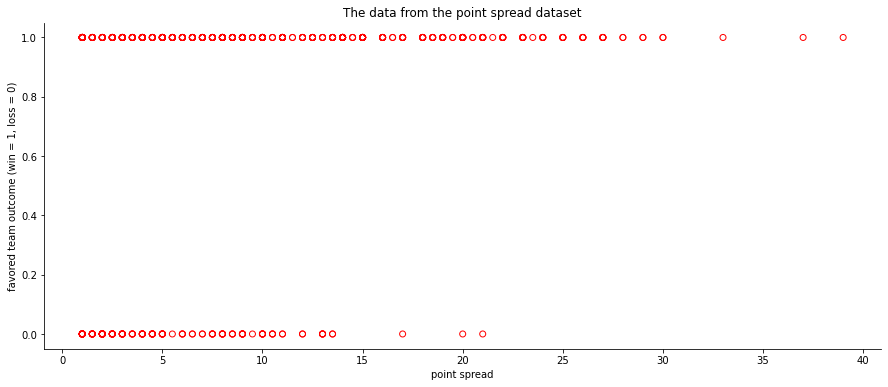

In [4]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter( vegas['spread'], vegas['favwin'], facecolors='none', edgecolors='red')

ax.set_ylabel('favored team outcome (win = 1, loss = 0)')
ax.set_xlabel('point spread')
ax.set_title('The data from the point spread dataset')

sea.despine(ax=ax)

### OLS

We begin with the linear probability model. The model is 

$$\text{Pr}(favwin=1 \mid spread) = \beta_0 + \beta_1 spread + \epsilon .$$

There is nothing new here technique-wise. We are estimating this with ols, see the ols notebook for a refresher.

In [5]:
# statsmodels adds a constant for us...
res_ols = smf.ols('favwin ~ spread', data=vegas).fit()

print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 favwin   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     68.57
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           9.32e-16
Time:                        13:13:23   Log-Likelihood:                -279.29
No. Observations:                 553   AIC:                             562.6
Df Residuals:                     551   BIC:                             571.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5769      0.028     20.434      0.0

### Hypothesis testing with t-test
If bookies were all-knowing, the spread would **exactly** account for the predictable winning probability and all we would be left with is the noise&mdash;the intercept should be one-half. Is it true in the data? We can use the `t_test( )` method of the results object to perform t-tests. 

The null hypothesis is $H_0: \beta_0 = 0.5$ and the alternative hypothesis is $H_1: \beta_0 \neq 0.5$.

In [6]:
t_test = res_ols.t_test('Intercept = 0.5')
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5769      0.028      2.725      0.007       0.521       0.632


Linear probability models have some problems. Perhaps the biggest one is that there is no guarantee that the predicted probability lies between zero and one! 

We can use the `fittedvalues` attribute of the results object to recover the fitted values of the y variables. Let's plot them and take a look. 

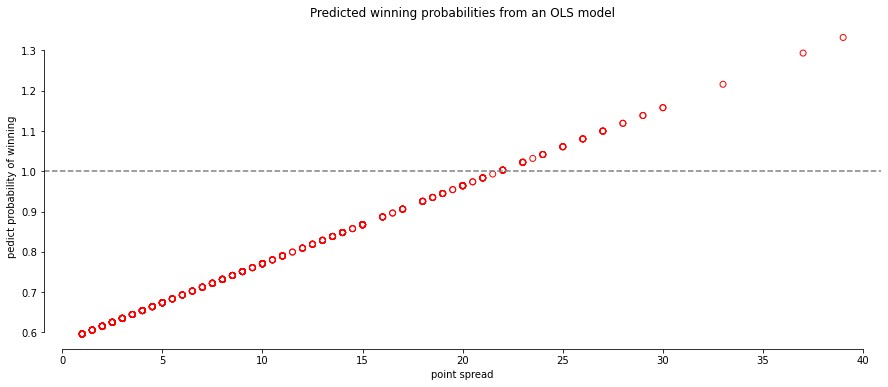

In [7]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(vegas['spread'], res_ols.fittedvalues,  facecolors='none', edgecolors='red')
ax.axhline(y=1.0, color='grey', linestyle='--')

ax.set_ylabel('pedict probability of winning')
ax.set_xlabel('point spread')
ax.set_title('Predicted winning probabilities from an OLS model')

sea.despine(ax=ax, trim=True)

### Logistic regression (logit)
The logistic regression passes the linear model through a non-linear function that constrains the output to lie between zero and one. (These functions are cumulative distribution functions.) In the logistic case, the function looks like

$$\text{prob} = \frac{\exp \left({\beta_0+\beta_1 spread}\right)}{1+\exp \left({\beta_0+\beta_1 spread}\right)},$$

and we predict a team wins when ever $\text{prob} \ge 0.5$.

We estimate the logit model with `logit( )` method from `smf` in a way similar to ols. 

In [8]:
res_log = smf.logit('favwin ~ spread', data=vegas).fit()
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.477218
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 favwin   No. Observations:                  553
Model:                          Logit   Df Residuals:                      551
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                  0.1283
Time:                        13:13:24   Log-Likelihood:                -263.90
converged:                       True   LL-Null:                       -302.75
Covariance Type:            nonrobust   LLR p-value:                 1.201e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0712      0.173     -0.411      0.681      -0.411       0.268
spread         0.1632      0.

Interpreting logit coefficients is bit more complicated. The probability that a team wins is given by the expression

$$\text{prob} = \frac{\exp \left({\beta_0+\beta_1 spread}\right)}{1+\exp \left({\beta_0+\beta_1 spread}\right)}$$

The `res_log.fittedvalues` seems to hold the fitted value of $\beta_0+\beta_1 spread$ and not the estimated probability. Let's compute it using the exp method of numpy. 


In [9]:
pred_probs = np.exp(res_log.fittedvalues) /( 1+np.exp(res_log.fittedvalues) )
pred_probs.describe()

count    553.000000
mean       0.763110
std        0.151419
min        0.523001
25%        0.622491
50%        0.774632
75%        0.901500
max        0.998157
dtype: float64

Plot the estimated probabilty of the favored team winning and the actual data. 

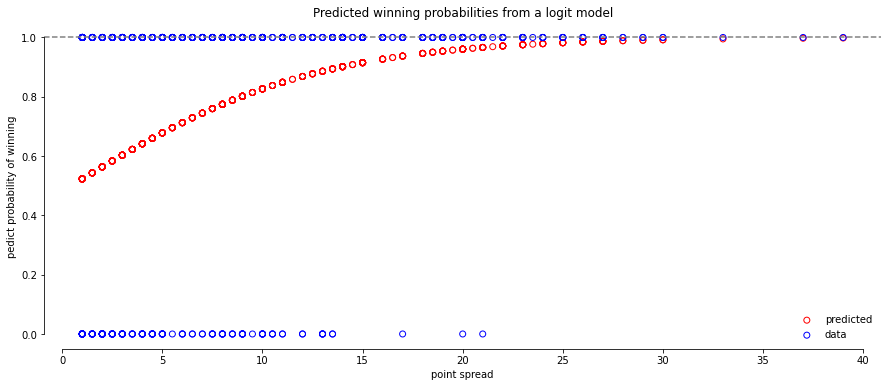

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

ax.scatter(vegas['spread'], pred_probs,  facecolors='none', edgecolors='red', label='predicted')
ax.scatter(vegas['spread'], vegas['favwin'],  facecolors='none', edgecolors='blue', label = 'data')
ax.axhline(y=1.0, color='grey', linestyle='--')

ax.set_ylabel('pedict probability of winning')
ax.set_xlabel('point spread')
ax.set_title('Predicted winning probabilities from a logit model')

ax.legend(frameon=False)
sea.despine(ax=ax, trim=True)

## Practice

Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. The TA and I are here, too.

1. Load the data 'apple.dta'. The data dictionary can be found [here](http://fmwww.bc.edu/ec-p/data/wooldridge/apple.des). The variable `ecolbs` is purchases of eco-friendly apples (whatever that means).  

In [11]:
#1

apple = pd.read_stata('apple.dta')

apple.head()

,id,educ,date,state,regprc,ecoprc,inseason,hhsize,male,faminc,age,reglbs,ecolbs,numlt5,num5_17,num18_64,numgt64
0,10002,16,111597,SD,1.19,1.19,1,4,0,45,43,2.0,2.000000,0,1,3,0
1,10004,16,121897,KS,0.59,0.79,0,1,0,65,37,0.0,2.000000,0,0,1,0
2,10034,18,111097,MI,0.59,0.99,1,3,0,65,44,0.0,2.666667,0,2,1,0
3,10035,12,111597,TN,0.89,1.09,1,2,1,55,55,3.0,0.000000,0,0,2,0
4,10039,15,122997,NY,0.89,1.09,0,1,1,25,22,0.0,3.000000,0,0,1,0


2. Create a variable named `ecobuy` that is equal to 1 if the observation has a positive purchase of eco-apples (i.e., ecolbs>0).

In [14]:
#2

apple['ecobuy'] = 0
apple.loc[(apple['ecolbs']> 0), 'ecobuy'] = 1
apple.head()

,id,educ,date,state,regprc,ecoprc,inseason,hhsize,male,faminc,age,reglbs,ecolbs,numlt5,num5_17,num18_64,numgt64,ecobuy
0,10002,16,111597,SD,1.19,1.19,1,4,0,45,43,2.0,2.000000,0,1,3,0,1
1,10004,16,121897,KS,0.59,0.79,0,1,0,65,37,0.0,2.000000,0,0,1,0,1
2,10034,18,111097,MI,0.59,0.99,1,3,0,65,44,0.0,2.666667,0,2,1,0,1
3,10035,12,111597,TN,0.89,1.09,1,2,1,55,55,3.0,0.000000,0,0,2,0,0
4,10039,15,122997,NY,0.89,1.09,0,1,1,25,22,0.0,3.000000,0,0,1,0,1


3. Estimate a linear probability model relating the probability of purchasing eco-apples to household characteristics. 

$$\text{ecobuy} = \beta_0 + \beta_1 \text{ecoprc} + \beta_2 \text{regprc} + \beta_3 \text{faminc} + \beta_4 \text{hhsize} + \beta_5 \text{educ} + \beta_6 \text{age} +  \epsilon$$

In [16]:
#3
ecobuy_linear = smf.ols('ecobuy ~ ecoprc + regprc + faminc + hhsize + educ + age', data = apple).fit()
print(ecobuy_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                 ecobuy   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     13.43
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           2.18e-14
Time:                        13:30:50   Log-Likelihood:                -419.60
No. Observations:                 660   AIC:                             853.2
Df Residuals:                     653   BIC:                             884.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4237      0.165      2.568      0.0

4. How many estimated probabilities are negative? Are greater than one?

In [18]:
#4
fitted = ecobuy_linear.fittedvalues   # store the fitted values
fitted[(fitted>1) | (fitted<0)]   # greater than 1 or less than zero

167    1.070860
493    1.054372
dtype: float64

5. Now estimate the model as a probit. A probit is similar to a logit in that we are passing the linear model through a nonlinear function. In this case, the nonlinear function is the cumulative density function of the normal distribution. 

$$\text{Pr}(\text{ecobuy}=1 \mid X) = \Phi \left(\beta_0 + \beta_1 \text{ecoprc} + \beta_2 \text{regprc} + \beta_3 \text{faminc} + \beta_4 \text{hhsize} + \beta_5 \text{educ} + \beta_6 \text{age} \right),$$

where $\Phi( )$ is the CDF of the normal distribution. Try `sfm.probit( )`.

In [20]:
#5
ecobuy_probit = smf.probit('ecobuy ~ ecoprc + regprc + faminc + hhsize + educ + age', data = apple).fit()
print(ecobuy_probit.summary())

Optimization terminated successfully.
         Current function value: 0.604599
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                 ecobuy   No. Observations:                  660
Model:                         Probit   Df Residuals:                      653
Method:                           MLE   Df Model:                            6
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                 0.08664
Time:                        13:38:10   Log-Likelihood:                -399.04
converged:                       True   LL-Null:                       -436.89
Covariance Type:            nonrobust   LLR p-value:                 2.751e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2438      0.474     -0.514      0.607      -1.173       0.685
ecoprc        -2.2669      0.

6. Compute the **marginal effects** of the coefficients at **the means** and print them out using `summary()`. You can get the marginal effects from the results object using `.get_margeff()`  [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.ProbitResults.get_margeff.html#statsmodels.discrete.discrete_model.ProbitResults.get_margeff). 

The marginal effect tells us the marginal change in predicted probability as the independent variables change.

In [23]:
#6
me_probit = ecobuy_probit.get_margeff(at='mean')
print(me_probit.summary())

       Probit Marginal Effects       
Dep. Variable:                 ecobuy
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ecoprc        -0.8508      0.120     -7.087      0.000      -1.086      -0.615
regprc         0.7619      0.143      5.334      0.000       0.482       1.042
faminc         0.0005      0.001      0.932      0.351      -0.001       0.002
hhsize         0.0259      0.014      1.894      0.058      -0.001       0.053
educ           0.0268      0.009      2.941      0.003       0.009       0.045
age           -0.0005      0.001     -0.340      0.734      -0.003       0.002


7. Re-estimate the model as a logit model. 

In [24]:
#7
ecobuy_logit = smf.logit('ecobuy ~ ecoprc + regprc + faminc + hhsize + educ + age', data = apple).fit()
print(ecobuy_logit.summary())

Optimization terminated successfully.
         Current function value: 0.604746
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 ecobuy   No. Observations:                  660
Model:                          Logit   Df Residuals:                      653
Method:                           MLE   Df Model:                            6
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                 0.08642
Time:                        13:44:54   Log-Likelihood:                -399.13
converged:                       True   LL-Null:                       -436.89
Covariance Type:            nonrobust   LLR p-value:                 3.017e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4278      0.786     -0.544      0.586      -1.968       1.112
ecoprc        -3.6773      0.

8. Compute the marginal effects of the logit coefficients. 

In [25]:
#8
me_logit = ecobuy_logit.get_margeff(at='mean')
print(me_logit.summary())

        Logit Marginal Effects       
Dep. Variable:                 ecobuy
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ecoprc        -0.8480      0.122     -6.972      0.000      -1.086      -0.610
regprc         0.7551      0.144      5.227      0.000       0.472       1.038
faminc         0.0006      0.001      1.012      0.311      -0.001       0.002
hhsize         0.0264      0.014      1.880      0.060      -0.001       0.054
educ           0.0273      0.009      2.931      0.003       0.009       0.046
age           -0.0005      0.001     -0.372      0.710      -0.003       0.002


We haven't done much data wrangling lately. I'm feeling a bit sad; I miss shaping data. 

9. Create a pandas DataFrame with the row index  'ecoprc', 'regprc', 'faminc', 'hhsize', 'educ', and 'age'. The columns should be labeled 'logit', 'probit', and 'ols'. The columns should contain the marginal effects for the logit and probit models and the coefficients from the ols model.

In [29]:
#9
params = pd.DataFrame({'logit':me_logit.margeff, 'probit':me_probit.margeff, 'ols':ecobuy_linear.params[1:]},
                      index = ['ecoprc', 'regprc', 'faminc', 'hhsize', 'educ', 'age'],
                     )
params


,logit,probit,ols
ecoprc,-0.848039,-0.850754,-0.802622
regprc,0.755077,0.761893,0.719268
faminc,0.000610,0.000543,0.000552
hhsize,0.026416,0.025947,0.023823
educ,0.027349,0.026784,0.024785
age,-0.000503,-0.000455,-0.000501
